In [19]:
import requests
import pandas as pd
import numpy as np
import re
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dianaow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dianaow/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Network Analysis for TIA articles
#### Extract articles

In [ ]:
df_results = pd.DataFrame()
for i in range(1, 31):
    res = requests.get('https://www.techinasia.com/wp-json/techinasia/2.0/posts/?page=' + str(i), headers={'User-Agent': 'Chrome'})
    if res:
        print('Response OK', i)
        tmp = pd.DataFrame(res.json()['posts'])
        df_results = pd.concat([df_results, tmp])
    else:
        print('Response Failed')

In [3]:
# Can only extract up to page 30
df_results.shape

(900, 29)

In [4]:
df_results = df_results.reset_index(drop=True)

In [5]:
df_results[df_results['slug'] == 'fabelio-bags-9m']

,id,date_gmt,modified_gmt,title,slug,status,type,link,content,vsitems,...,tags,companies,is_sponsored,sponsor,is_partnership,external_scripts,show_ads,is_subscriber_exclusive,is_paywalled,read_time
18,649852,2020-06-17T09:36:49,2020-06-17T09:46:28,Indonesian furniture e-tailer Fabelio bags $9m...,fabelio-bags-9m,publish,post,https://www.techinasia.com/fabelio-bags-9m,"<p><a href=""https://fabelio.com/"" target=""_bla...",[],...,"[{'id': '12092', 'name': 'appWorks', 'slug': '...",[],False,"{'logo': None, 'name': None, 'link': None}",False,None,True,False,True,3


In [20]:
def convert(x):
    utc = datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')
    return utc.strftime("%Y-%m-%d")

df_results['date_local'] = df_results['date_gmt'].apply(lambda x: convert(x))

In [21]:
title = []
for i,row in df_results.iterrows():
    title.append({'author': df_results['author'][i]['display_name'], 'title': df_results['seo'][i]['title'], \
                 'comment_count': df_results['comments_count'][i], 'day_month': df_results['date_local'][i], \
                 'avatar': df_results['author'][i]['avatar_url']})
df_new = pd.DataFrame(title)

### Author information
#### Article count, comment count

In [22]:
# Author name with avatar image (only have detailed tooltip information for authors)
# He/she contributed a total of _____ articles, with a total of ____ comments => summary.csv
# (?) Article count ranking (show only if within top 5) => summary.csv
# (?) Comment count ranking (show only if within top 5) => summary.csv
# (?) He/she has the most similar articles to _____, based on article title and categories. => summary.csv
# (?) Top 3 commented articles (list the top 3 titles)  => summary.csv
# Top 3 categories (with % occurrence) => edges.csv
# Top 3 keywords (with % occurrence) => edges.csv
# Timeline of postings (heatmap) => timeline.csv
article_count = pd.DataFrame(df_new.groupby('author')['title'].count()).reset_index().sort_values('title', ascending=False)
comment_count = pd.DataFrame(df_new.groupby('author')['comment_count'].sum()).reset_index().sort_values('comment_count', ascending=False)
df_summary = pd.merge(article_count, comment_count, on='author', how='left')
df_summary['comment_avg'] = df_summary['comment_count'] / df_summary['title']
df_summary = df_summary.rename(columns={'author': 'id', 'title': 'article_count'})

for i,row in df_summary.iterrows():
    df_summary.loc[i, 'avatar'] = df_new[df_new['author'] == df_summary.loc[i, 'id']].head(1)['avatar'].values[0]

df_summary.to_csv('./data/summary.csv', index=False)

####  Timeline of article contribution

In [343]:
timeline_overall = df_new.groupby(['day_month'])['title'].count().reset_index()\
    .sort_values('title', ascending=False).rename(columns={'title': 'total'})
timeline_overall['id'] = 'Overall'

In [344]:
df_timeline = df_new.groupby(['author', 'day_month'])['title'].count().reset_index()\
    .sort_values('title', ascending=False).rename(columns={'title': 'total', 'author': 'id'})
df_timeline = pd.concat([df_timeline, timeline_overall])
df_timeline.to_csv('./data/timeline.csv', index=False)

### Extract categories tagged to posts

In [25]:
cat = []
for i,row in df_results.iterrows():   
    for x in df_results['categories'][i]:   
        #cat.append({'categories': x['name'], 'author': df_results['author'][i]['display_name']})
        cat.append({'categories': x['name'], 'author': df_results['author'][i]['display_name'], 'id': df_results['id'][i]})
df_categories = pd.DataFrame(cat)
df_categories = df_categories.sort_values(['id', 'categories'], ascending=True)

In [26]:
categories = [x.lower() for x in df_categories['categories'].unique()]

In [27]:
categories 

['events',
 'investments',
 'landscape reports',
 'premium content',
 'startups',
 'recruitment',
 'tech in asia jobs',
 'asia',
 'fintech',
 'featured stories',
 'news',
 'announcements',
 'ecommerce',
 'tia partnership',
 'videos',
 'community',
 'opinion',
 'internet',
 'profiles',
 'social media',
 'analysis',
 'digital marketing',
 'artificial intelligence',
 'management',
 'transportation',
 'acquisitions',
 'blockchain',
 'gaming',
 'visual stories',
 'trends',
 'consumer tech',
 'mobile',
 'business-to-business',
 'tips',
 'product management',
 'q&a',
 'media',
 'data science',
 'tia originals',
 'conference',
 'design',
 'engineering',
 'greentech',
 'robotics',
 'gadgets',
 'web development']

#### Association Rules: Find category tags that occur together

In [130]:
def get_rules(lst, metric):
    te=TransactionEncoder()
    te_data=te.fit(lst).transform(lst)
    data_x=pd.DataFrame(te_data,columns=te.columns_)

    frequent_items= apriori(data_x, use_colnames=True, min_support=0.01)

    rules = association_rules(frequent_items, metric="lift", min_threshold=1)
    rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
    rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))


    df_rules = rules.groupby(['antecedents', 'consequents'])[[metric]].max().sort_values(ascending=False,by=metric).reset_index()
    df_rules['sorted_row'] = [sorted([a,b]) for a,b in zip(df_rules['antecedents'], df_rules['consequents'])]
    df_rules['sorted_row'] = df_rules['sorted_row'].astype(str)
    df_rules.drop_duplicates(subset=['sorted_row'], inplace=True)
    
    return df_rules

/Users/dianaow/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


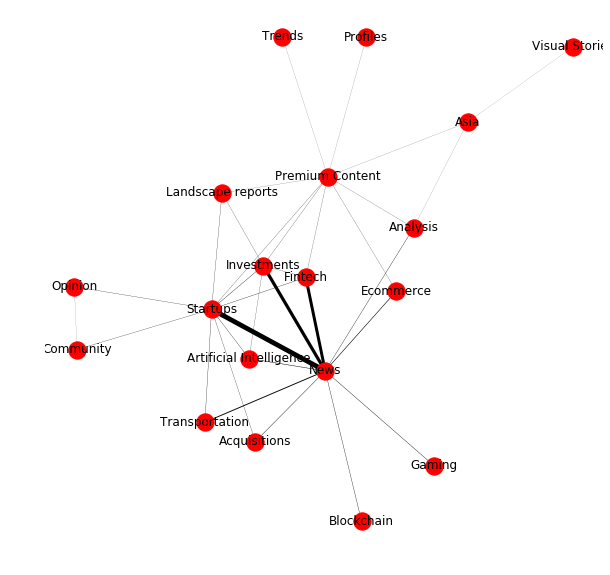

In [161]:
lst = list(df_categories.groupby('id')['categories'].apply(list))
df_rules_category = get_rules(lst, 'support')
df_rules_category['count'] = df_rules_category['support'] * len(df_results)

fig, ax=plt.subplots(figsize=(10,10))
GA=nx.from_pandas_edgelist(df_rules_category,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True, width=list(df_rules_category['count']/100))
plt.show()

### Extract keywords from post titles

In [30]:
wnl = WordNetLemmatizer() 

# add categories to stop words
stop = stopwords.words('english')
for i in categories:
    stop.append(i)
stop = set(stop)

In [31]:
def tokenizer(text):

    tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]

    tokens = []
    for token_by_sent in tokens_:
        tokens += token_by_sent

    tokens = list(filter(lambda t: t.lower() not in stop, tokens))
    tokens = list(filter(lambda t: t not in punctuation, tokens))
    tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', u'\u2014', u'\u2026', u'\u2013'], tokens))
     
    filtered_tokens = []
    for token in tokens:
        token = wnl.lemmatize(token)
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)

    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

    return filtered_tokens

#### Checking the effects of the tokenizer

In [32]:
df_new['title'][1]

'The Weekly Snapshot: News from Grab, One Championship, Jio Platforms, and more'

In [33]:
tokenizer(df_new['title'][1])

['weekly', 'snapshot', 'grab', 'one', 'championship', 'jio', 'platforms']

In [34]:
df_new['title'][50]

'5-month-old startup raises $10.5m from Sequoia, Lightspeed'

In [35]:
tokenizer(df_new['title'][50])

['5-month-old', 'startup', 'raise', '10.5m', 'sequoia', 'lightspeed']

#### Build the tfidf matrix with the titles

In [36]:
text_content = df_new['title']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                         tokenizer=tokenizer,
                         min_df=1,      # only use words that appear at least X times
                         max_features=100,
                         lowercase=True, # Convert everything to lower case 
                         use_idf=True,   # Use idf
                         norm=u'l2',     # Normalization
                         smooth_idf=True # Prevents divide-by-zero errors
                         )
tfidf = vector.fit_transform(text_content)

In [38]:
names = vector.get_feature_names()
cv = CountVectorizer(vocabulary=names)
newVec = cv.fit_transform(text_content)
df_counts = pd.DataFrame(newVec.toarray(), columns=names)

In [139]:
keywords = []
for i,row in df_new.iterrows(): 
    df_counts_t = pd.DataFrame(df_counts.transpose()[i]).reset_index().rename(columns={i: 'has'})
    df_counts_1 = df_counts_t[df_counts_t['has'] > 0]
    for x,row in df_counts_1.iterrows(): 
        keywords.append({'keywords': df_counts_1.loc[x, 'index'], 'author': df_new['author'][i], \
                         'title': df_new['title'][i], 'id': df_results['id'][i]})
df_keywords = pd.DataFrame(keywords)

#### Cosine Similarity: Find similar article titles based on keywords

In [62]:
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

In [63]:
find_similar(tfidf, 0, top_n = 5)

[382, 92, 573, 506, 149]

In [65]:
for i in df_new.loc[[0, 382, 92, 573, 506, 149], 'title']:
    print(i)

Jendela360 bags $1m in Beenext-led round
Seoul-based Energy X bags $5.1m in Hyundai-led round
Intelllex bags $2.1m in Quest Ventures-led round
Novocall bags $500k in 500 Startups-led round
India's CureFit bags $110m in Temasek-led round
Crypto exchange CoinDCX bags $2.5m from Polychain, Coinbase


In [71]:
find_similar(tfidf, 200, top_n = 10)

[556, 330, 229, 700, 669, 781, 282, 348, 526, 482]

In [72]:
for i in df_new.loc[[200, 556, 330, 229, 700, 669, 781, 282, 348, 526, 482], 'title']:
    print(i)

A roadmap for online travel’s long, painful path to recovery
Tech in Asia’s Product Development Conference is moving online!
Does Quube have a wholesale platform online?
Gojek enters online investments, starting with gold
Pakistani online grocery startup MandiExpress raises $725k
Online personal care brand LetsShave bags funding from Wipro
Cashfree is making life easier for online companies in India
Online furniture retailers turn to AR amid the pandemic
[Updated] Dubious practices, ‘profiteering’ taint Indonesia’s bid to regulate online lending
Yijiupi eyes larger pie of China's online procurement market
Future Indonesia: How Tokopedia uses the cloud to make online shopping more seamless


#### Which keywords commonly paired together?

In [44]:
Xc = (newVec.T * newVec) # This is the matrix manipulation step
Xc.setdiag(0)
co_matrix = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)

/Users/dianaow/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


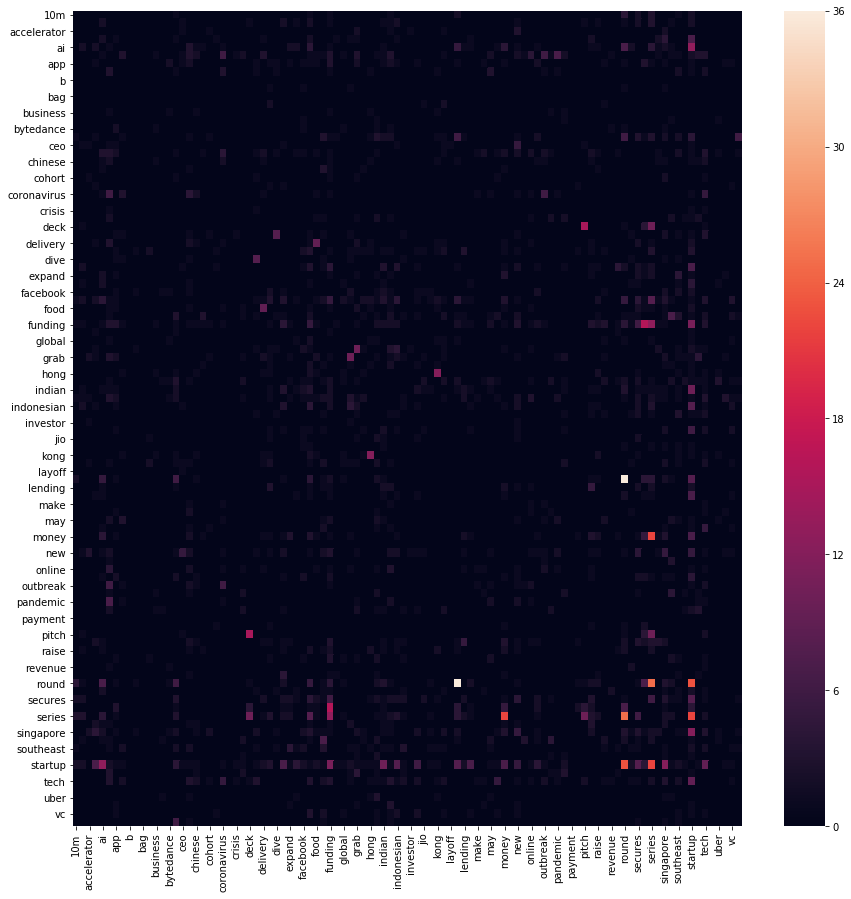

In [45]:
plt.figure(figsize=(15,15))
sns.heatmap(co_matrix)

#### Association Rules: Find keywords that occur together

In [140]:
# replace similar keywords not picked up lemmetizer
df_keywords = df_keywords.replace(to_replace = ['fund', 'funds', 'funding','funded'], value ="fund") 
df_keywords = df_keywords.replace(to_replace = ['launch', 'launches', 'launching','launched'], value ="launch") 
df_keywords = df_keywords.replace(to_replace = ['coronavirus', 'covid-19', 'pandemic'], value ="coronavirus")
df_keywords = df_keywords.replace(to_replace = ['firms', 'firm'], value ="firms")
df_keywords = df_keywords.replace(to_replace = ['china', 'chinese'], value ="china")
df_keywords = df_keywords.replace(to_replace = ['india', 'indian'], value ="india")
df_keywords = df_keywords.replace(to_replace = ['indonesia', 'indonesian'], value ="indonesia")
df_keywords = df_keywords.replace(to_replace = ['investor', 'investment', 'investments','investing', 'invested', 'invests'], value ="investment")
df_keywords = df_keywords.replace(to_replace = ['pay', 'payment', 'payments'], value ="pay")
df_keywords = df_keywords.replace(to_replace = ['hong', 'kong'], value ="hong kong")

/Users/dianaow/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


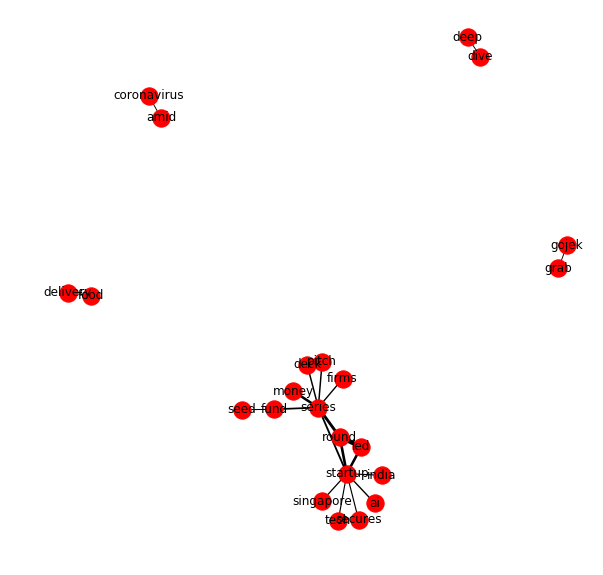

In [142]:
lst1 = list(df_keywords.groupby('id')['keywords'].apply(list))
df_rules_keywords = get_rules(lst1, 'support')
df_rules_keywords['count'] = df_rules_keywords['support'] * len(df_results)

fig, ax=plt.subplots(figsize=(10,10))
GA=nx.from_pandas_edgelist(df_rules_keywords,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True, width=list(df_rules_keywords['count']/10))
plt.show()

In [350]:
# checking how keywords appear in titles
# keyowrds like 'venture' and 'capital' seem to be able to form the word 'venture capital', but i will keep it separated
# Capital seems of be part of many company names
for i in df_keywords[df_keywords['keywords'] == 'capital']['title'].head(10):
    print(i)

The most active venture capital firms in Southeast Asia
Wallex raises series A funding from BAce Capital, others
EDBI, Seeds Capital launch $205m fund for Singapore startups
Wiz nets $6m in pre-series A round led by GGV Capital
Is RBF an alternative to traditional loans and venture capital?
India's Khatabook raises $60m in round led by B Capital
FoodRazor bags $900k in seed round led by Cocoon Capital
Helicap scores $10m in round led by Saison Capital
Sequoia Capital names 15 startups in third Surge cohort
The most active venture capital firms in China


In [349]:
# As also seen in the graph above, series, money, round, funding, pitch deck frequently appear together in article titles
for i in df_keywords[df_keywords['keywords'] == 'series']['title'].head(10):
    print(i)

Thai fintech firm Synqa rakes in $80m in series C funding
Indonesian logistics startup Shipper bags series A money
Furniture e-tailer Fabelio bags $9m in series C1 money
Thai proptech startup ZmyHome bags pre-series A money
Wallex raises series A funding from BAce Capital, others
The series B pitch deck that landed Pendo $20m
Healthtech startup Ubie bags $18.7m in series B money
E-scooter startup Beam raises $26m in series A round
Insurtech startup PolicyStreet banks $1.8m in series A money
Front’s series A pitch deck


#### Final round of keywords trimming
- Manually remove verbs, descriptive verbs and numbers
- Manually remove very highly paired words 

In [60]:
to_keep = ['app', 'asian', 'bank', 'bytedance', 'capital', 'ceo', 'china', 'coronavirus', 'crisis', 'delivery',\
           'digital', 'edtech', 'facebook', 'fund', 'global', 'gojek', 'grab', 'honestbee', 'hong kong', 'india',\
           'indonesia', 'jio', 'job', 'launch', 'layoff', 'money', 'online', 'oyo', 'pay', 'platform', 'sea', \
           'seed', 'series', 'service', 'singapore', 'softbank', 'southeast', 'staff', 'tech', 'tencent', 'uber', \
           'unicorn', 'venture']

In [143]:
df_keywords = df_keywords[df_keywords['keywords'].isin(to_keep)]

/Users/dianaow/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


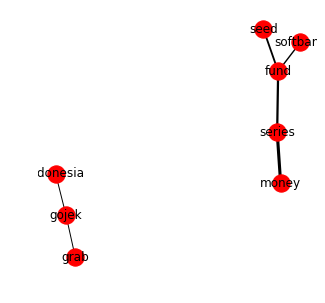

In [152]:
# Recalculate the association rules for the finalized set of keywords
lst1 = list(df_keywords.groupby('id')['keywords'].apply(list))
df_rules_keywords = get_rules(lst1, 'support')
df_rules_keywords['count'] = df_rules_keywords['support'] * len(df_results)

fig, ax=plt.subplots(figsize=(5,5))
GA=nx.from_pandas_edgelist(df_rules_keywords,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True, width=list(df_rules_keywords['count']/10))
plt.show()

#### Association rules: Find categories and keywords that commonly occur together 
- Links can also be established between categories and keywords, by calculating association rules after combining categories and keywords. This would an additional 50 edges.
- Some keywords-keywords edges will be lost. Eg. Softbank - fund, becomes Softbank - News instead.
- To prevent the graph from becoming too dense and risk hairball graphs, i will not include them in the network

/Users/dianaow/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


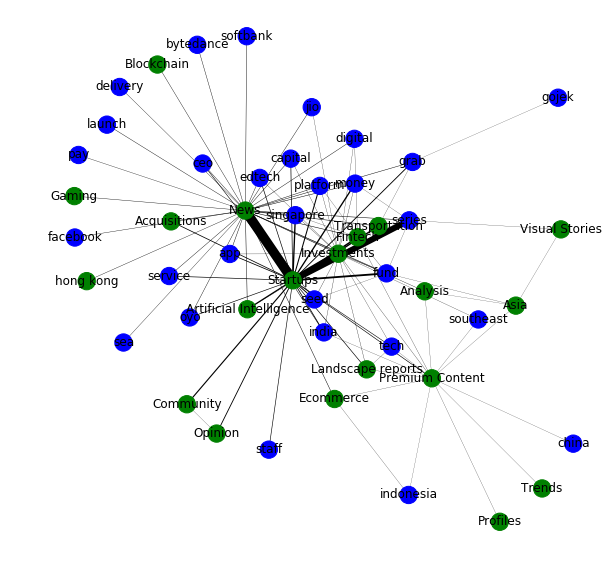

In [333]:
df_keywords_categories = pd.concat([df_keywords, df_categories.rename(columns={'categories': 'keywords'})])
lst2 = list(df_keywords_categories.groupby('id')['keywords'].apply(list))
df_rules = get_rules(lst2, 'support')
df_rules['count'] = df_rules['support'] * len(df_results)

fig, ax=plt.subplots(figsize=(10,10))
GA=nx.from_pandas_edgelist(df_rules,source='antecedents',target='consequents')
color_map = []
for node in GA:
    if node in names:
        color_map.append('blue')
    else: 
        color_map.append('green') 
nx.draw(GA,with_labels=True, node_color=color_map, width=list(df_rules['count']/50))
plt.show()

### Construct graph edges

In [245]:
keywords_edges = pd.DataFrame(df_keywords.groupby(['author', 'keywords'])['keywords'].count())\
    .rename(columns={'keywords': 'total'}).reset_index()\
    .sort_values('total', ascending=False).rename(columns={'author': 'start_id', 'keywords': 'end_id'})
keywords_edges['category'] = 'author-keywords'

In [246]:
categories_edges = pd.DataFrame(df_categories.groupby(['author', 'categories'])['categories'].count())\
    .rename(columns={'categories': 'total'}).reset_index()\
    .sort_values('total', ascending=False).rename(columns={'author': 'start_id', 'categories': 'end_id'})
categories_edges['category'] = 'author-categories'

In [247]:
wn_keywords_edges = df_rules_keywords.rename(columns={'antecedents': 'start_id', 'consequents': 'end_id',\
                                                      'count': 'total'})[['start_id', 'end_id', 'total']]
wn_keywords_edges['category'] = 'keywords-keywords'

In [248]:
wn_categories_edges = df_rules_category.rename(columns={'antecedents': 'start_id', 'consequents': 'end_id',\
                                                      'count': 'total'})[['start_id', 'end_id', 'total']]
wn_categories_edges['category'] = 'categories-categories'

In [284]:
edges = pd.concat([categories_edges, keywords_edges, wn_keywords_edges, wn_categories_edges]).reset_index(drop=True)

In [285]:
edges.shape

(879, 4)

In [286]:
np.percentile(edges['total'].values,50)

1.0

In [287]:
# Trim the number of edges by only keeping edges with count above the 50th percentile
edges = edges[edges['total'] > 1]

In [288]:
edges.shape

(410, 4)

In [314]:
edges.sort_values('total', ascending=False).head()

,start_id,end_id,total,category
846,News,Startups,479.0,categories-categories
847,News,Investments,319.0,categories-categories
848,Startups,Investments,297.0,categories-categories
0,Miguel Cordon,News,230.0,author-categories
1,Doris Yu,News,225.0,author-categories


In [290]:
edges.to_csv('./data/edges.csv', index=False)

### Construct graph nodes

In [291]:
author_nodes = df_new.groupby('author').count().reset_index()\
    .rename(columns={'title': 'total', 'author': 'id'}).sort_values('total', ascending=False)
author_nodes = author_nodes[['id', 'total']]
author_nodes['category'] = 'author'

In [292]:
categories_nodes = df_categories.groupby('categories').count().reset_index()\
    .rename(columns={'author': 'total'}).sort_values('total', ascending=False)
categories_nodes['category'] = 'categories'
categories_nodes = categories_nodes.drop(['id'], axis=1).rename(columns={'categories': 'id'})

In [293]:
keywords_nodes = df_keywords.groupby('keywords')['author'].count().reset_index()\
    .rename(columns={'author': 'total', 'keywords': 'id'}).sort_values('total', ascending=False)
keywords_nodes['category'] = 'keywords'

In [294]:
nodes = pd.concat([keywords_nodes, categories_nodes, author_nodes]).reset_index(drop=True)

In [295]:
nodes.shape

(186, 3)

In [296]:
#METHOD 1
#np.percentile(nodes['total'].values,50)
#Trim the number of nodes by only keeping nodes with count above the 50th percentile
#nodes = nodes[nodes['total'] > 6]

In [297]:
# METHOD 2
# Note: Not all authors will be displayed within the network
# Only keep nodes found as the start and end id of edges
nodes_to_keep = np.concatenate((edges['start_id'].unique(),edges['end_id'].unique()), axis=0)
nodes = nodes[nodes['id'].isin(nodes_to_keep)]

In [298]:
nodes.shape

(130, 3)

In [299]:
nodes.head()

,id,total,category
0,fund,87,keywords
1,series,77,keywords
2,indonesia,57,keywords
3,india,55,keywords
4,singapore,52,keywords


In [300]:
nodes.to_csv('./data/nodes.csv', index=False)

In [301]:
# Checks: How many authors are left out of the network after filtering
txt = "{} authors contributed articles"
orig = len(df_summary['id'])
print(txt.format(orig))

txt1 = "There are a total of {} authors left in network after filtering"
filt = len(nodes[nodes['category'] == 'author']['id'])
print(txt1.format(filt))

99 authors contributed articles
There are a total of 55 authors left in network after filtering


## Network Exploration

In [302]:
G = nx.Graph()

for index, row in edges.iterrows():
    G.add_edge(row["start_id"], row["end_id"], weight=row["total"], category=row["category"])
    
for index, row in nodes.iterrows():
    G.add_node(row["id"], weight=row["total"], category=row["category"])

In [315]:
# Its messy, use d3 force-layout to further customize the graph on the web browser
# There doesn't seem to be any floating nodes
#fig, ax=plt.subplots(figsize=(16,16))
#color_map_nodes = {'author':'#f09494', 'categories':'#eebcbc', 'keywords':'#72bbd0'}
#color_map_edges = {'author-keywords':'#000000', 'author-categories':'#000000','keywords-keywords':'#629fff', 'categories-categories':'#bcc2f2'}
#node_color= [color_map_nodes[d['category']] for n,d in G.nodes(data=True)]
#edge_color= [color_map_edges[e[2]['category']] for e in G.edges(data=True)]
#node_size = [d['weight']*10 for n,d in G.nodes(data=True)]
#edge_width = [e[2]['weight']/10 for e in G.edges(data=True)]
#pos = nx.drawing.spring_layout(G,k=0.70,iterations=60)
#nx.draw_networkx(G,pos=pos, node_color=node_color, node_size=node_size, edge_color=edge_color, edge_width=edge_width)
#plt.show()

### Descriptive statistics

In [310]:
# The graph has only a single connected component
nx.number_connected_components(G)

1

In [311]:
# Graph density
nx.density(G)

0.04889683959451401

In [312]:
# The diameter of a graph is the length of the longest path among all the shortest path that link any two nodes
nx.diameter(G)

6

#### Degree distribution
- The distribution is scale-free.There is a large number of nodes that have a small degree, but a significant number of nodes have a high degree.

(array([85., 27., 10.,  2.,  2.,  0.,  0.,  1.,  1.,  2.]),
 array([ 1. ,  5.8, 10.6, 15.4, 20.2, 25. , 29.8, 34.6, 39.4, 44.2, 49. ]),
 <a list of 10 Patch objects>)

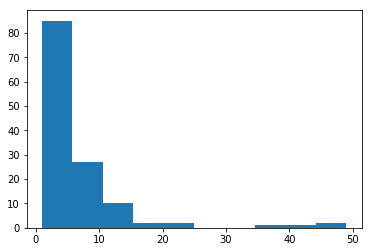

In [183]:
plt.hist([node[1] for node in list(G.degree())])

### Centrality Measures
- To evaluate the importance of some entities in a network

#### Degree centrality
- The number of neighbors that a node has normalized to the number of individuals it could be connected to in the entire graph

In [189]:
sorted(nx.degree_centrality(G).items(), key=lambda x:x[1], reverse=True)[0:10]

[('Doris Yu', 0.3798449612403101),
 ('Startups', 0.3488372093023256),
 ('Miguel Cordon', 0.34108527131782945),
 ('News', 0.3023255813953488),
 ('Premium Content', 0.18604651162790697),
 ('Investments', 0.17829457364341084),
 ('Terence Lee', 0.12403100775193798),
 ('Kenan Machado', 0.12403100775193798),
 ('TIA Visuals', 0.11627906976744186),
 ('TIA Bot', 0.11627906976744186)]

In [203]:
cor = pd.DataFrame.from_records([nx.pagerank_numpy(G, weight='weight'), \
                                 nx.betweenness_centrality(G, weight='weight'),\
                                 nx.degree_centrality(G)])
cor.T.corr().rename(columns={0:'pagerank', 1:'betweeness', 2:'degree'}, \
                    index={0:'pagerank', 1:'betweeness', 2:'degree'})

,pagerank,betweeness,degree
pagerank,1.000000,0.624050,0.897096
betweeness,0.624050,1.000000,0.794066
degree,0.897096,0.794066,1.000000


#### Pagerank (extension of eigenvector_centrality)
- This measure uncovers nodes whose influence extends beyond their direct connections into the wider network.

In [185]:
sorted(nx.pagerank_numpy(G, weight=None).items(), key=lambda x:x[1], reverse=True)[0:10]

[('Doris Yu', 0.055223635515049774),
 ('Miguel Cordon', 0.04888786182527342),
 ('Startups', 0.0483316199727581),
 ('News', 0.04091436755942857),
 ('Premium Content', 0.02372446024711856),
 ('Investments', 0.022459643971468154),
 ('Kenan Machado', 0.017301403619148104),
 ('TIA Bot', 0.016946910391743154),
 ('Terence Lee', 0.0167764594011343),
 ('Stefanie Yeo', 0.015726678568002077)]

In [186]:
sorted(nx.pagerank_numpy(G, weight='weight').items(), key=lambda x:x[1], reverse=True)[0:10]

[('News', 0.11782890093558161),
 ('Startups', 0.11032900228191427),
 ('Miguel Cordon', 0.07554918870739136),
 ('Investments', 0.0737913844867795),
 ('Doris Yu', 0.07256556712542173),
 ('Premium Content', 0.032263664680878844),
 ('Fintech', 0.021921162278515906),
 ('Stefanie Yeo', 0.01304903125056008),
 ('TIA Bot', 0.01240703779746226),
 ('Asia', 0.012188231746059255)]

#### Betweeness centrality
- This measure shows which nodes are ‘bridges’ between nodes in a network. It does this by identifying all the shortest paths and then counting how many times each node falls on one.

In [187]:
sorted(nx.betweenness_centrality(G).items(), key=lambda x:x[1], reverse=True)[0:10]

[('Startups', 0.25269734690296486),
 ('Doris Yu', 0.24881290875487255),
 ('Miguel Cordon', 0.1890039888278589),
 ('News', 0.14149680706635281),
 ('tech', 0.08435498514943567),
 ('Stefanie Yeo', 0.05752177292863482),
 ('hong kong', 0.05539269993224463),
 ('Asia', 0.050647002890373265),
 ('TIA Bot', 0.04363813778186497),
 ('Premium Content', 0.042983719068897176)]

In [188]:
sorted(nx.betweenness_centrality(G, weight='weight').items(), key=lambda x:x[1], reverse=True)[0:10]

[('Doris Yu', 0.24245165087547116),
 ('Startups', 0.1924481150364999),
 ('tech', 0.11499717310037079),
 ('coronavirus', 0.102476512901017),
 ('Miguel Cordon', 0.08966587503480457),
 ('indonesia', 0.08956379893666144),
 ('Asia', 0.08935543690267521),
 ('TIA Bot', 0.08039127498397762),
 ('Putra Muskita', 0.07717947917588817),
 ('Stefanie Yeo', 0.06809347891288298)]

#### Adamic Adar: Finding similar nodes 

In [317]:
adamic = pd.DataFrame(list(nx.adamic_adar_index(G)))

In [321]:
# Should i normalize the similarity scores?
#scaler = MinMaxScaler()
#adamic[2] = scaler.fit_transform(np.array(adamic[2]).reshape(-1, 1))

In [322]:
adamic.sort_values(2, ascending=False)[0:20]

,0,1,2
5125,Miguel Cordon,Doris Yu,29.692021
1320,Kenan Machado,Doris Yu,7.124911
1363,Kenan Machado,Miguel Cordon,7.124911
4962,TIA Bot,Doris Yu,6.118000
4980,TIA Bot,Miguel Cordon,6.118000
663,Premium Content,News,5.706122
4004,Melissa Goh,Doris Yu,5.665539
2800,Startups,indonesia,5.507918
6959,TIA Visuals,Doris Yu,5.486547
5120,Miguel Cordon,Putra Muskita,5.223984
